# Notebook to investigate Dense Network [Last Mass]

In [1]:
# imports
from random import randint
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as tfkl
import tensorflow_datasets as tfds
from tqdm import trange
# import my_dataset
import matplotlib.pyplot as plt
data_dir='/gpfsscratch/rech/qrc/commun/tensorflow_datasets'

In [28]:
from sfh.datasets.tng100 import tng100
dset = tfds.load('tng100', split='train', data_dir=data_dir)

In [30]:
for example in dset.take(1):
    #example=preprocessing(example)
    print(example.keys())

dict_keys(['Mstar', 'Mstar_Half', 'SFR_Max', 'SFR_Rad', 'SFR_halfRad', 'last_major_merger', 'last_over_max', 'mass_quantiles', 'noiseless_griz', 'object_id', 'sed', 'stellar_light', 'time', 'velocity_dispersion_map', 'velocity_map'])


In [31]:
tf.reduce_all(example['Mstar_Half'] == 0)

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [33]:
img200 = []
for example in examples:
    img200.append(example['noiseless_griz'].numpy())

In [39]:
np.ravel(img200).std()

9.816043

Populating the interactive namespace from numpy and matplotlib


/gpfs7kro/gpfslocalsup/pub/anaconda-py3/2021.05/envs/tensorflow-gpu-2.6.0/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


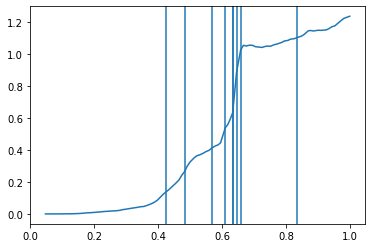

In [4]:
%pylab inline
plot(example['time'], example['Mstar'])
for i in example['mass_quantiles']:
    axvline(i)

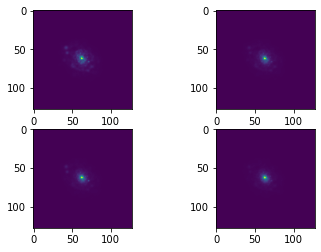

In [7]:
imgs = example['noiseless_griz']
example['noiseless_griz'].shape
fig, ax = plt.subplots(2, 2)
ax = ax.flatten()
for i in range(4):
    ax[i].imshow(imgs[..., i])

In [41]:
norm_imgs = preprocessing(example)[0]

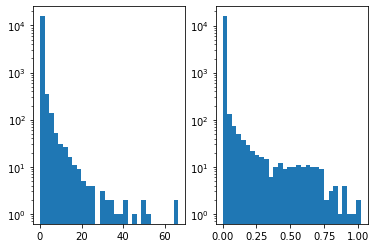

In [42]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(tf.reshape(imgs[..., 0], 128*128).numpy(), log=True, bins=30)
ax[1].hist(tf.reshape(norm_imgs[..., 0], 128*128).numpy(), log=True, bins=30);

In [3]:
# functions

def Model(nb_summaries):
    """ Creates a small fully connected network
    """
    return tf.keras.Sequential([
        tfkl.Input(shape=(128, 128, 4)),
        tfkl.Conv2D(16, 3, strides=2, activation='relu', padding='same'),
        tfkl.Conv2D(32, 3, strides=2, activation='relu', padding='same'),
        tfkl.Conv2D(64, 3, strides=2, activation='relu', padding='same'),
        tfkl.Conv2D(64, 3, strides=2, activation='relu', padding='same'),
        tfkl.Flatten(),
        tfkl.Dense(128, activation='relu'),
        tfkl.Dense(1, activation='softplus')
        ])

import tensorflow_probability as tfp

def ModelProba(nb_summaries):
    """ Creates a CNN with probabilistic output
    """
    num_components = 16
    event_shape = [1]
    return tf.keras.Sequential([
        tfkl.Input(shape=(128, 128, 4)),
        tfkl.Conv2D(16, 3, strides=2, activation='relu', padding='same'),
        tfkl.Conv2D(32, 3, strides=2, activation='relu', padding='same'),
        tfkl.Conv2D(64, 3, strides=2, activation='relu', padding='same'),
        tfkl.Conv2D(64, 3, strides=2, activation='relu', padding='same'),
        tfkl.Flatten(),
        tfkl.Dense(128, activation='relu'),
        tfkl.Dense(tfp.layers.MixtureNormal.params_size(num_components, event_shape)),
        tfp.layers.MixtureNormal(num_components, event_shape),
        ])


def preprocessing(example):
    # Magic constants (from mergers_kin_scripts)
    std_noiseless_griz = 9.816043
    stellar_light_compression = 3.0
    img0 = example['noiseless_griz']
    img0 = tf.where(tf.math.is_nan(img0), tf.zeros_like(img0), img0)
    img0 = tf.where(tf.math.is_inf(img0), tf.zeros_like(img0), img0)
    img0 = tf.math.asinh(img0 / tf.constant(std_noiseless_griz) * tf.constant(stellar_light_compression) ) / tf.constant(stellar_light_compression)

    return img0, example['Mstar_Half'][0]

def preprocessing_test(example):
    # Magic constants (from mergers_kin_scripts)
    std_noiseless_griz = 9.816043
    stellar_light_compression = 3.0
    
    img0 = example['noiseless_griz']
    img0 = tf.where(tf.math.is_nan(img0), tf.zeros_like(img0), img0)
    img0 = tf.where(tf.math.is_inf(img0), tf.zeros_like(img0), img0)
    img0 = tf.math.asinh(img0 / tf.constant(std_noiseless_griz) * tf.constant(stellar_light_compression) ) / tf.constant(stellar_light_compression)

    return img0, example['Mstar_Half'][0], example['Mstar_Half'], example['time'], example['mass_quantiles']

def input_fn(mode='train', batch_size=32):
    """
    mode: 'train' or 'test'
    """
    def has_sfh(example):
        print(example)
        return not tf.reduce_all(example['Mstar_Half'] == 0)

    if mode == 'train':
        dataset = tfds.load('tng100', split='train[:80%]', data_dir=data_dir)
        dataset = dataset.filter(has_sfh) # adding a filtering condition to exclude empty catalogs
        dataset = dataset.map(preprocessing) # Apply data preprocessing
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
        #dataset = dataset.filter(lambda x: x['last_over_max'] > 0.9) # adding a filtering condition to gold samples
    else:
        dataset = tfds.load('tng100', split='train[80%:]', data_dir=data_dir)
        #dataset = dataset.filter(lambda x: x['has_sfh'] == True) # adding a filtering condition to exclude empty catalogs
        #dataset = dataset.filter(lambda x: x['last_over_max'] > 0.9) # adding a filtering condition to gold samples
        dataset = dataset.map(preprocessing_test) # Apply data preprocessing
    
    dataset = dataset.batch(batch_size, drop_remainder=True)

    dataset = dataset.prefetch(-1)  # fetch next batches while training current one (-1 for autotune)
    return dataset

In [3]:
model = Model(1)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        592       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               524416    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

2021-12-09 12:46:18.251877: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 12:46:18.895100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [41]:
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

In [5]:


model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MSE, metrics=['accuracy'])
label = 'img_cnn_last-mass'
EPOCHS = 100
now = str(datetime.datetime.now())[0:16].replace('-','_').replace(' ','_').replace(':','_')
checkpoint_filepath = '/gpfsscratch/rech/qrc/commun/sfhsed/checkpoint/'+label+'/'+now
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)
# The model weights (that are considered the best) are loaded into the model.

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
dset = input_fn(mode='train', batch_size=32)
history = model.fit(dset, steps_per_epoch=200, epochs=EPOCHS, callbacks=[model_checkpoint_callback, lr_decay])

{'Mstar': <tf.Tensor 'args_0:0' shape=(100,) dtype=float32>, 'Mstar_Half': <tf.Tensor 'args_1:0' shape=(100,) dtype=float32>, 'SFR_Max': <tf.Tensor 'args_2:0' shape=(100,) dtype=float32>, 'SFR_Rad': <tf.Tensor 'args_3:0' shape=(100,) dtype=float32>, 'SFR_halfRad': <tf.Tensor 'args_4:0' shape=(100,) dtype=float32>, 'last_major_merger': <tf.Tensor 'args_5:0' shape=() dtype=float32>, 'last_over_max': <tf.Tensor 'args_6:0' shape=() dtype=float32>, 'mass_quantiles': <tf.Tensor 'args_7:0' shape=(9,) dtype=float32>, 'noiseless_griz': <tf.Tensor 'args_8:0' shape=(128, 128, 4) dtype=float32>, 'object_id': <tf.Tensor 'args_9:0' shape=() dtype=int32>, 'sed': <tf.Tensor 'args_10:0' shape=(143,) dtype=float32>, 'stellar_light': <tf.Tensor 'args_11:0' shape=(512, 512) dtype=float32>, 'time': <tf.Tensor 'args_12:0' shape=(100,) dtype=float32>, 'velocity_dispersion_map': <tf.Tensor 'args_13:0' shape=(512, 512) dtype=float32>, 'velocity_map': <tf.Tensor 'args_14:0' shape=(512, 512) dtype=float32>}
Epoc

2021-12-09 12:47:55.319548: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-09 12:48:05.413953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 7110 of 10000
2021-12-09 12:48:07.466363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-12-09 12:48:08.016208: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


200/200 [==============================] - 20s 27ms/step - loss: 6.1918 - accuracy: 0.0000e+00
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009000000000000001.
200/200 [==============================] - 5s 24ms/step - loss: 4.0615 - accuracy: 0.0000e+00
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0008100000000000001.
200/200 [==============================] - 5s 24ms/step - loss: 4.1610 - accuracy: 0.0000e+00
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0007290000000000002.
200/200 [==============================] - 5s 24ms/step - loss: 4.1852 - accuracy: 0.0000e+00
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0006561000000000001.
200/200 [==============================] - 5s 24ms/step - loss: 2.2607 - accuracy: 0.0000e+00
Epoch 6/100

Epoch 00006: LearningRateScheduler setting learning rate to 0.00059049.
200/200 [==============================] - 10s 48ms/step - l

In [12]:
checkpoint_filepath = '/gpfsdswork/projects/rech/qrc/uzu97zj/AstroInfo2021/tmp/tmp'
#checkpoint_filepath = '/gpfsdswork/projects/rech/qrc/uzu97zj/AstroInfo2021/tmp/tmp'
model.load_weights(checkpoint_filepath)
#history = model.fit(dset, steps_per_epoch=200, epochs=EPOCHS, callbacks=[model_checkpoint_callback])
# plt.plot(history.loss)


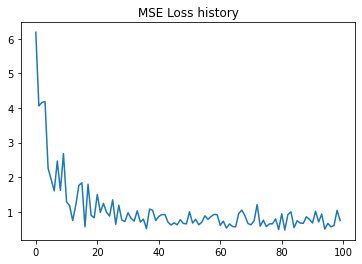

In [7]:
%matplotlib inline
plt.figure()
plt.plot(np.arange(len(model.history.history['loss'])), model.history.history['loss'])
#plt.yscale('log')
plt.title('MSE Loss history')
plt.show()

testing loss

In [14]:
dset_test = input_fn(mode='test', batch_size=128)

In [15]:
i = 0
truthes = []
predicted = []
for ibatch, features in enumerate(dset_test):
    truth = features[1]
    truthes.append(truth)
    predict = model.predict(features[0])
    predicted.append(predict)
    i = i + 1

In [16]:
truthes = np.ravel(truthes)
predicted = np.ravel(predicted)

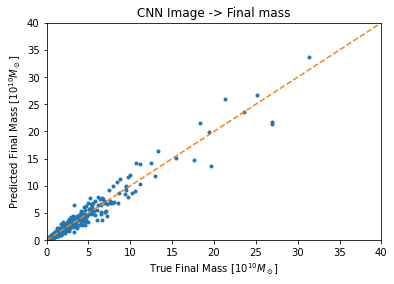

In [25]:
plt.plot(truthes, predicted, '.')
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.plot([0, 40], [0, 40], '--')
plt.xlabel('True Final Mass [$10^{10}M_\odot$]')
plt.ylabel('Predicted Final Mass [$10^{10}M_\odot$]')
plt.title('CNN Image -> Final mass')
plt.savefig('CNN-image-final_mass.pdf')

In [23]:
pwd

'/gpfsdswork/projects/rech/qrc/ups48kf/AstroInfo2021/sfh-inference-hackathon/notebooks'

In [25]:
# k = 0
# fig, ax = plt.subplots(6, 1, figsize=(5, 10))
# for batch, features in enumerate(dset_test):
#     if batch > 1:
#         break
#     predict = model.predict(features[0])
#     for j, gal in enumerate(features):
#         if j >6:
#             break
# #         ax[k, 0].plot(np.arange(len(features[0][0])), features[0][0])
#         ax[k].plot(features[3][0], features[2][0])
        
#         ax[k].scatter(1, predict[j], marker='x', color='red', s=10)
#         k += 1
#         #ax[k,1].set_ylim(0,1.5)
                  

In [30]:
features.shape

AttributeError: 'tuple' object has no attribute 'shape'

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/tensorflow-gpu-2.6.0/bin/xpython:5: RuntimeWarning: divide by zero encountered in log10


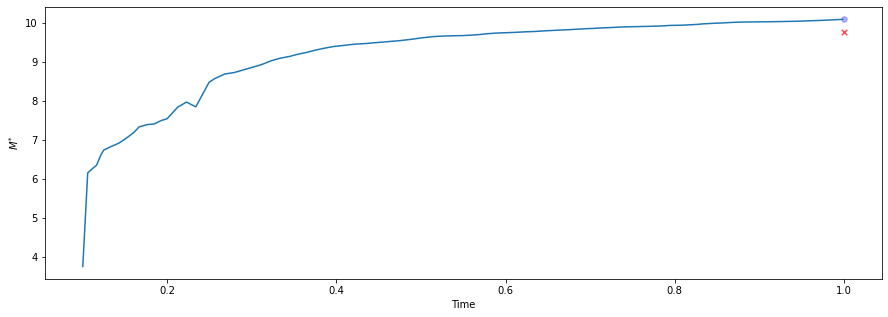

In [49]:
k = randint(0, len(features[0]))
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# features = np.ma.masked_values(features[2],0)
ax.plot(features[3][k], np.log10(features[2][k])+10)
#np.log10(features[2][k])+10
predict[k] = np.ma.masked_values(predict[k],0)
ax.scatter(1, np.log10(predict[k])+10, marker='x', color='red', s=30, alpha=0.7)
ax.scatter(1, np.log10(features[2][k][0])+10, marker='o', color='blue', s=30, alpha=0.3)
ax.set_xlabel('Time')
ax.set_ylabel('$M^{*}$');
plt.show()

In [50]:
err = []
m_m = []
err_n = []
#features = np.ma.masked_values(features[2],0)
#predict[k] = np.ma.masked_values(predict[k],0)
for row in np.arange(len(features[0])):
    error = (features[2][row][0].numpy() - predict[row][0])
    m_max = features[2][row][0].numpy()
    if features[2][row][0].numpy() != 0:
        error_n = (features[2][row][0].numpy() - predict[row][0])/features[2][row][0].numpy()
    err.append(error)
    err_n.append(error_n)
    m_m.append(m_m)

Text(0.5, 0, '$M_{data} - M_{predicted}$')

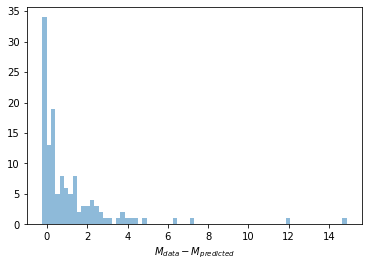

In [51]:
err = np.ma.masked_values(err,0)
err = np.ma.masked_values(err,np.inf)
plt.hist(err, bins=70, alpha=0.5);
plt.xlabel(r'$M_{data} - M_{predicted}$')
#err

Text(0.5, 0, '$\\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$')

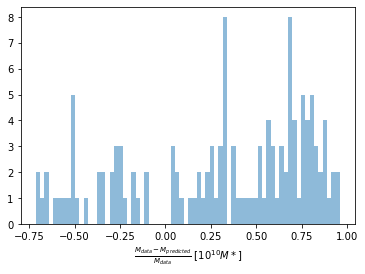

In [52]:
err = np.ma.masked_values(err,0)
err = np.ma.masked_values(err,np.inf)
plt.hist(err_n, bins=70, alpha=0.5);
plt.xlabel(r'$\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$')
#err

Text(0.5, 0, '$\\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$')

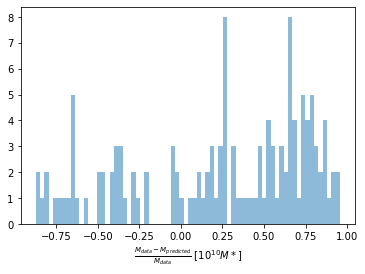

In [23]:
err = np.ma.masked_values(err,0)
err = np.ma.masked_values(err,np.inf)
plt.hist(err_n, bins=70, alpha=0.5);
plt.xlabel(r'$\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$')
#err

Text(0.5, 0, '$\\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$')

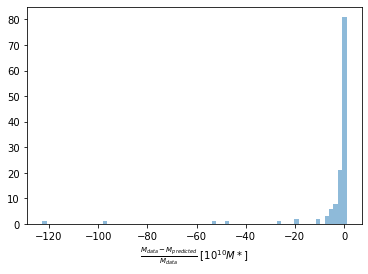

In [60]:
%matplotlib inline
err = np.ma.masked_values(err,0)
err = np.ma.masked_values(err,np.inf)
plt.hist(err_n, bins=70, alpha=0.5);
plt.xlabel(r'$\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$');
#err

In [64]:
np.quantile(err_n,0.68)

0.454129558801651

In [4]:
model_proba = ModelProba(1)
model_proba.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        592       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               524416    
_________________________________________________________________
dense_1 (Dense)              (None, 48)                6

2021-12-09 15:30:00.614774: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 15:30:01.257088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2021-12-09 15:30:01.643515: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [5]:
def negloglik(y_true, y_pred):
    # instead of tf.keras.losses.MSE
    return -y_pred.log_prob(y_true)

model_proba.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=negloglik, metrics=['accuracy'])
label = 'img_cnnproba_last-mass'
EPOCHS = 40
now = str(datetime.datetime.now())[0:16].replace('-','_').replace(' ','_').replace(':','_')
checkpoint_filepath = '/gpfsscratch/rech/qrc/commun/sfhsed/checkpoint/'+label+'/'+now
model_proba_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

In [6]:
LEARNING_RATE=0.0001
LEARNING_RATE_EXP_DECAY=0.9

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

dset = input_fn(mode='train', batch_size=32)
history = model_proba.fit(dset, steps_per_epoch=200, epochs=EPOCHS, callbacks=[model_proba_checkpoint_callback, lr_decay])

{'Mstar': <tf.Tensor 'args_0:0' shape=(100,) dtype=float32>, 'Mstar_Half': <tf.Tensor 'args_1:0' shape=(100,) dtype=float32>, 'SFR_Max': <tf.Tensor 'args_2:0' shape=(100,) dtype=float32>, 'SFR_Rad': <tf.Tensor 'args_3:0' shape=(100,) dtype=float32>, 'SFR_halfRad': <tf.Tensor 'args_4:0' shape=(100,) dtype=float32>, 'last_major_merger': <tf.Tensor 'args_5:0' shape=() dtype=float32>, 'last_over_max': <tf.Tensor 'args_6:0' shape=() dtype=float32>, 'mass_quantiles': <tf.Tensor 'args_7:0' shape=(9,) dtype=float32>, 'noiseless_griz': <tf.Tensor 'args_8:0' shape=(128, 128, 4) dtype=float32>, 'object_id': <tf.Tensor 'args_9:0' shape=() dtype=int32>, 'sed': <tf.Tensor 'args_10:0' shape=(143,) dtype=float32>, 'stellar_light': <tf.Tensor 'args_11:0' shape=(512, 512) dtype=float32>, 'time': <tf.Tensor 'args_12:0' shape=(100,) dtype=float32>, 'velocity_dispersion_map': <tf.Tensor 'args_13:0' shape=(512, 512) dtype=float32>, 'velocity_map': <tf.Tensor 'args_14:0' shape=(512, 512) dtype=float32>}
Epoc

2021-12-09 15:30:06.086849: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-09 15:30:16.228683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 7107 of 10000
2021-12-09 15:30:18.240577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-12-09 15:30:18.810391: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


200/200 [==============================] - 20s 27ms/step - loss: 3.2172 - accuracy: 0.0000e+00
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 9e-05.
200/200 [==============================] - 5s 24ms/step - loss: 1.0385 - accuracy: 0.0000e+00
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 8.1e-05.
200/200 [==============================] - 5s 24ms/step - loss: 0.6582 - accuracy: 0.0000e+00
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 7.290000000000001e-05.
200/200 [==============================] - 5s 24ms/step - loss: 0.3494 - accuracy: 0.0000e+00
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 6.561e-05.
200/200 [==============================] - 5s 24ms/step - loss: 0.1578 - accuracy: 0.0000e+00
Epoch 6/40

Epoch 00006: LearningRateScheduler setting learning rate to 5.904900000000001e-05.
200/200 [==============================] - 10s 48ms/step - loss: 0.0708 - accuracy: 0.0000e+00
E

In [7]:
checkpoint_filepath = '/gpfsscratch/rech/qrc/commun/sfhsed/checkpoint/img_cnnproba_last-mass/2021_12_09_14_26'
#checkpoint_filepath = '/gpfsdswork/projects/rech/qrc/uzu97zj/AstroInfo2021/tmp/tmp'
status = model_proba.load_weights(checkpoint_filepath)
#history = model.fit(dset, steps_per_epoch=200, epochs=EPOCHS, callbacks=[model_checkpoint_callback])
# plt.plot(history.loss)

Text(0.5, 1.0, 'MSE Loss history')

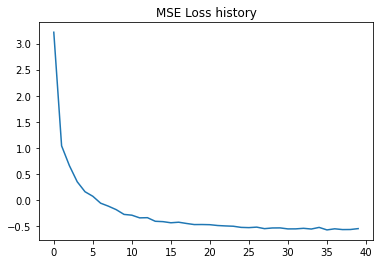

In [8]:
plt.figure()
plt.plot(np.arange(len(model_proba.history.history['loss'])), model_proba.history.history['loss'])
#plt.yscale('log')
plt.title('MSE Loss history')

In [9]:
dset_test = input_fn(mode='test', batch_size=128)
features = dset_test.take(1)

In [10]:
i = 0
truthes = []
predicted_mean = []
predicted_std = []
for ibatch, features in enumerate(dset_test):
    truth = features[1]
    truthes.append(truth)
    predict = model_proba(features[0])
    predicted_mean.append(predict.mean())
    predicted_std.append(predict.stddev())
    i = i + 1
truthes = np.ravel(truthes)
predicted_mean = np.ravel(predicted_mean)
predicted_std = np.ravel(predicted_std)

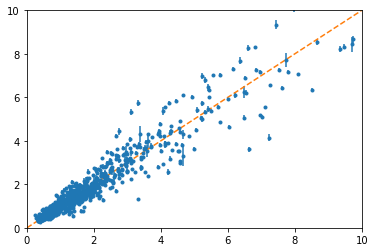

In [11]:
plt.errorbar(truthes, predicted_mean, predicted_std, marker='.', ls='')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.plot([0, 10], [0, 10], '--')

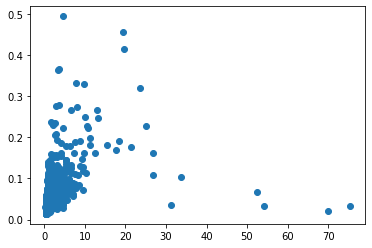

In [12]:
plt.scatter(truthes, predicted_std)